In [1]:
import dicom
import matplotlib.pyplot as plt

%matplotlib inline

from pathlib import Path
import tensorflow as tf
import numpy as np
from tqdm import tqdm_notebook
import scipy.misc
from skimage import io
import scipy.stats
import seaborn as sns
import skimage.color
from skimage.filters import threshold_otsu
import keras

from matplotlib import animation
from IPython.display import HTML
from PIL import Image
import pandas as pd

dicom_files = [x for x in Path('../Data/torso/rfmri/MR').iterdir() if x.is_file() and not 'ds_store' in str(x).lower()]
dicom_files.sort(key=str)

pig0 = dicom.read_file(str(dicom_files[22]), force=True)
im = pig0.pixel_array


all_data = np.zeros((120, 47, im.shape[0], im.shape[1]))

for f in tqdm_notebook(dicom_files):
    pigfile = dicom.read_file(str(f), force=True)
    
    try:
    
        time = (pigfile.InstanceNumber - 1) // 47
        depth = pigfile.InStackPositionNumber - 1


        if np.count_nonzero(all_data[time, depth]) > 0:
            print('repeated stack position @ time %d , depth %d' % (time, depth))

        all_data[time, depth, ...] = pigfile.pixel_array
    except:
        print(f)
        
# use annotation to select pixels from volume
binary_mask = io.imread('../Data/torso/t0_bin_segment_v1.tif')
indices = np.nonzero(binary_mask)
df_index = pd.MultiIndex.from_tuples(list(zip(*indices)), names=['depth', 'row', 'col'])
series_df = pd.Series(index=df_index, dtype=object)

for i, triple in tqdm_notebook(enumerate(zip(*indices)), total=len(indices[0])):
    d, r, c = triple
    trace = all_data[:, d, r, c]
    series_df.loc[triple] = trace
    
data_block = np.vstack(series_df.values)[..., np.newaxis]
shuffled_data = np.copy(data_block)
np.random.shuffle(shuffled_data)
validation_set = shuffled_data[:1000]

Using TensorFlow backend.


In [3]:
from keras.models import load_model
m = load_model('model_e9.h5')

m.evaluate(validation_set, validation_set)

 992/1000 [============================>.] - ETA: 0s

3343.320623046875

In [4]:
layer_14 = m.layers[14]
layer_14.get_config()

{'name': 'max_pooling1d_3',
 'padding': 'valid',
 'pool_size': (2,),
 'strides': (2,),
 'trainable': True}

In [5]:
from sklearn import manifold
from time import time

embedding_model = keras.models.Model(inputs=m.input,
                                 outputs=m.layers[14].output)
embeddings = embedding_model.predict(data_block)
squished_embeddings = np.reshape(embeddings, (embeddings.shape[0], -1))

print(embeddings.shape)
print(squished_embeddings.shape)

(13550, 15, 256)
(13550, 3840)


In [6]:
np.save('../Data/numpy-data/e9-embeddings-squished.npy', squished_embeddings)

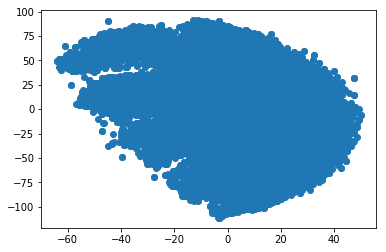

In [7]:
tsne_100 = manifold.TSNE(n_components=2, init='random', random_state=0, n_iter=5000, perplexity=100)
tsne_100_result = tsne_100.fit_transform(squished_embeddings)
plt.scatter(tsne_100_result[:, 0], tsne_100_result[:, 1])
plt.savefig('../Results/tsne_e9/tsne_100_pig_1_full_dataset.png')
np.save('../Data/numpy-data/e9_tsne_100_full_dataset.npy', tsne_100_result) 


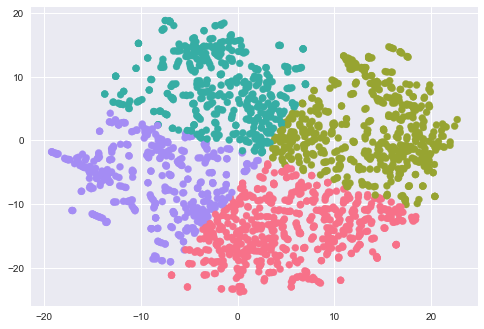

In [16]:
# color (kmeans) and label
from sklearn.cluster import KMeans
qualitative_clusters = 4

my_kmeans = KMeans(n_clusters=qualitative_clusters, n_init=50)

rgbs = [np.array(c) for c in sns.color_palette("husl", qualitative_clusters)]

my_kmeans.fit(tsne_10_result)
labels = my_kmeans.labels_
colors = [rgbs[i] for i in labels]

plt.scatter(tsne_10_result[:, 0], tsne_10_result[:, 1], c=colors)



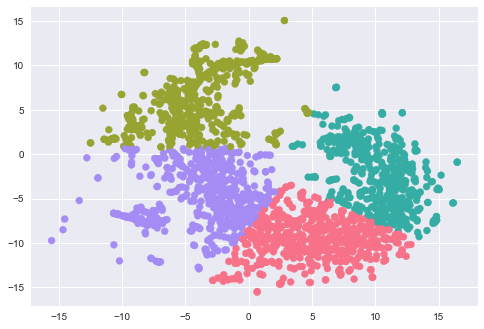

In [17]:
# color (kmeans) and label
from sklearn.cluster import KMeans
qualitative_clusters = 4

my_kmeans = KMeans(n_clusters=qualitative_clusters, n_init=50)

rgbs = [np.array(c) for c in sns.color_palette("husl", qualitative_clusters)]

my_kmeans.fit(tsne_50_result)
labels = my_kmeans.labels_
colors = [rgbs[i] for i in labels]

plt.scatter(tsne_50_result[:, 0], tsne_50_result[:, 1], c=colors)


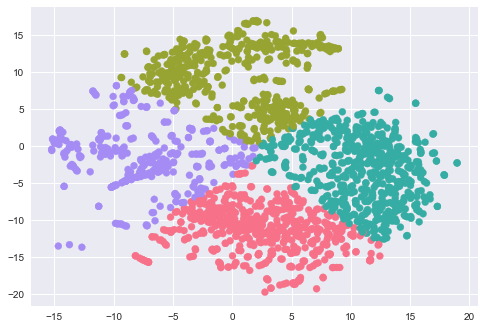

In [18]:
# color (kmeans) and label
from sklearn.cluster import KMeans
qualitative_clusters = 4

my_kmeans = KMeans(n_clusters=qualitative_clusters, n_init=50)

rgbs = [np.array(c) for c in sns.color_palette("husl", qualitative_clusters)]

my_kmeans.fit(tsne_25_result)
labels = my_kmeans.labels_
colors = [rgbs[i] for i in labels]

plt.scatter(tsne_25_result[:, 0], tsne_25_result[:, 1], c=colors)


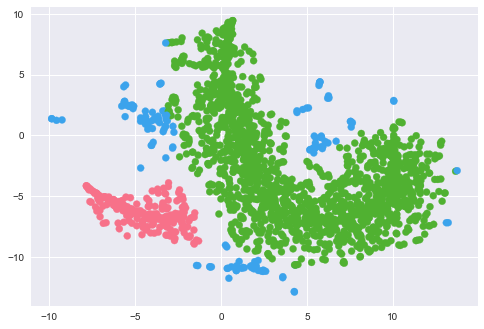

In [21]:
# color (kmeans) and label
from sklearn.cluster import KMeans, DBSCAN

db = DBSCAN(eps=2,min_samples=100)
db.fit_predict(tsne_100_result)
labels = db.labels_
rgbs = [np.array(c) for c in sns.color_palette("husl", len(np.unique(labels)))]
colors = [rgbs[i] for i in labels]


# qualitative_clusters = 2
# my_kmeans = KMeans(n_clusters=qualitative_clusters, n_init=50)
# my_kmeans.fit(tsne_100_result)
# labels = my_kmeans.labels_

plt.scatter(tsne_100_result[:, 0], tsne_100_result[:, 1], c=colors)


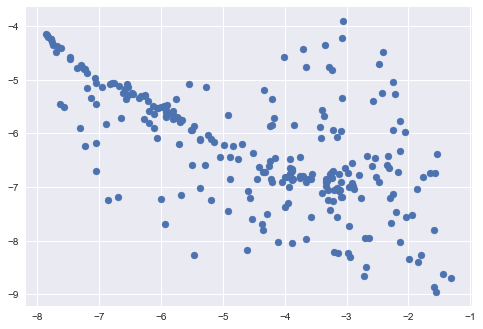

In [28]:
small_island = tsne_100_result[labels == 0]
plt.scatter(small_island[:,0], small_island[:,1])

255


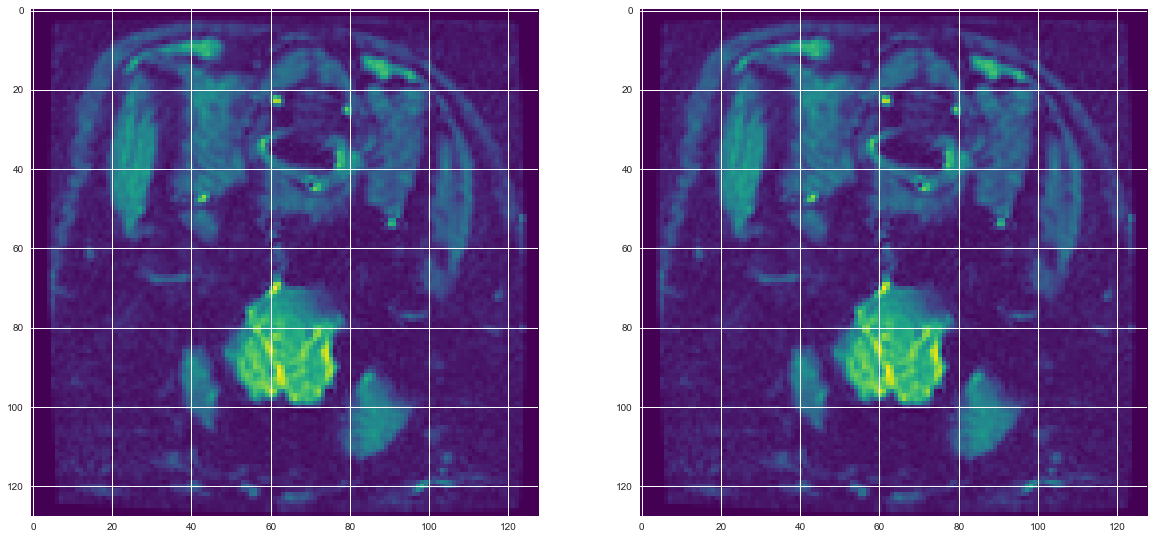

In [93]:
slice_i = 30
plt.figure(figsize=(20,10))
small_island_indices = series_df.index[:2000][labels == 0]
print(len(small_island_indices))
plt.subplot(1, 2, 1)
plt.imshow(all_data[0, slice_i], cmap='viridis')

plt.subplot(1, 2, 2)
plt.imshow(all_data[0, slice_i], cmap='viridis')
for p in small_island_indices:
    if p[0] == slice_i:
        pass
        plt.scatter(x=p[2], y=p[1], c='r', s=40)


In [103]:
print(np.unique(labels))
print(len(np.unique(labels)))

[-1  0]
2


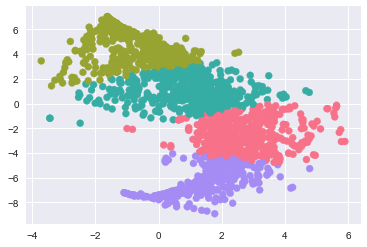

In [96]:
# color (kmeans) and label
from sklearn.cluster import KMeans
qualitative_clusters = 4

my_kmeans = KMeans(n_clusters=qualitative_clusters, n_init=50)

rgbs = [np.array(c) for c in sns.color_palette("husl", qualitative_clusters)]

my_kmeans.fit(tsne_500_result)
labels = my_kmeans.labels_
colors = [rgbs[i] for i in labels]

plt.scatter(tsne_500_result[:, 0], tsne_500_result[:, 1], c=colors)


In [79]:
indices_for_group_1 = np.where(labels == 1)[0]
indices_for_group_2 = np.where(labels == 2)[0]
indices_for_group_3 = np.where(labels == 3)[0]